In [77]:
from pathlib import Path
import pandas as pd
import numpy as np
from glob import glob
import os
import seaborn as sns
import xarray as xr

import matplotlib.pyplot as plt

sns.set(font="Helvetica")

In [2]:
diri = r'/Users/fadhlilrizki/Documents/PhD/thesis/data/'

In [3]:
ds   = xr.open_dataset(diri+"agcd_v1_precip_calib_r025_daily_1981-2020.masked.nc")
ds

<xarray.Dataset>
Dimensions:    (time: 14396, bnds: 2, lon: 177, lat: 138)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01T09:00:00 ... 2020-05-31T09:00:00
  * lon        (lon) float32 112.0 112.2 112.5 112.8 ... 155.2 155.5 155.8 156.0
  * lat        (lat) float32 -44.5 -44.25 -44.0 -43.75 ... -10.75 -10.5 -10.25
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    precip     (time, lat, lon) float32 ...
Attributes: (12/35)
    CDI:                       Climate Data Interface version 2.1.0 (https://...
    source:                    Data is from site-based observation data recor...
    institution:               Australian Bureau of Meteorology, GPO Box 1289...
    Conventions:               CF-1.6, ACDD-1.3
    geospatial_lat_min:        -44.525
    geospatial_lat_max:        -9.975
    ...                        ...
    description:               This AGCD data is a snapshot of the operationa...
    date_issued:               2020-12-02 05:42:26
    attribution:               Data should be cited as : Australian Bureau of...
    copyright:                 (C) Copyright Commonwealth of Australia 2020, ...
    history:                   Tue Jul 04 14:03:37 2023: cdo mul /Users/fadhl...
    CDO:                       Climate Data Operators version 2.1.0 (https://...

In [4]:
prec = ds.precip
prec

<xarray.DataArray 'precip' (time: 14396, lat: 138, lon: 177)>
[351636696 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01T09:00:00 ... 2020-05-31T09:00:00
  * lon      (lon) float32 112.0 112.2 112.5 112.8 ... 155.2 155.5 155.8 156.0
  * lat      (lat) float32 -44.5 -44.25 -44.0 -43.75 ... -10.75 -10.5 -10.25
Attributes:
    standard_name:                 lwe_thickness_of_precipitation_amount
    long_name:                     Daily precipitation
    units:                         mm
    cell_methods:                  time: sum
    analysis_version_number:       3.01
    number_of_stations_reporting:  6600
    frequency:                     daily
    length_scale_for_analysis:     80.0
    coverage_content_type:         physicalMeasurement

In [5]:
latS = -15
latN = -9
lonL = 129
lonR = 137

In [6]:
prec_TE = prec.sel(lon=slice(lonL,lonR),lat=slice(latS,latN),time=slice("1981-01-01","2018-12-31"))
prec_TE

<xarray.DataArray 'precip' (time: 13879, lat: 20, lon: 33)>
[9160140 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01T09:00:00 ... 2018-12-31T09:00:00
  * lon      (lon) float32 129.0 129.2 129.5 129.8 ... 136.2 136.5 136.8 137.0
  * lat      (lat) float32 -15.0 -14.75 -14.5 -14.25 ... -10.75 -10.5 -10.25
Attributes:
    standard_name:                 lwe_thickness_of_precipitation_amount
    long_name:                     Daily precipitation
    units:                         mm
    cell_methods:                  time: sum
    analysis_version_number:       3.01
    number_of_stations_reporting:  6600
    frequency:                     daily
    length_scale_for_analysis:     80.0
    coverage_content_type:         physicalMeasurement

In [7]:
weights = np.cos(np.deg2rad(prec_TE.lat))
weights.name = "weights"
weights

<xarray.DataArray 'weights' (lat: 20)>
array([0.9659258 , 0.96704596, 0.96814764, 0.9692309 , 0.9702957 ,
       0.9713421 , 0.9723699 , 0.97337925, 0.97437006, 0.97534233,
       0.976296  , 0.9772311 , 0.9781476 , 0.97904545, 0.9799247 ,
       0.98078525, 0.98162717, 0.9824504 , 0.9832549 , 0.9840407 ],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -15.0 -14.75 -14.5 -14.25 ... -10.75 -10.5 -10.25
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y

In [8]:
prec_TE_weighted = prec_TE.weighted(weights)
prec_TE_weighted

DataArrayWeighted with weights along dimensions: lat

In [9]:
prec_TE_mean = prec_TE_weighted.mean(("lon", "lat")).to_dataframe()
prec_TE_mean_time = prec_TE_mean.index.normalize()
prec_TE_mean = prec_TE_mean.set_index(prec_TE_mean_time)

prec_TE_mean

,precip
time,
1981-01-01,1.220795
1981-01-02,0.590377
1981-01-03,2.167974
1981-01-04,1.438496
1981-01-05,11.632874
...,...
2018-12-27,6.002585
2018-12-28,4.433438
2018-12-29,1.113171


In [10]:
diri_wphase = "/Users/fadhlilrizki/Documents/PhD/thesis/dataout/local_wave_phase/"
fw_1 = "local_er_phase_SHSummer.133.nc"


In [11]:
dfw_1 = xr.open_dataset(diri_wphase+fw_1)
dfw_1 = dfw_1.sel(time=slice("1981-01-1","2018-12-31"))

In [12]:
dfw_er_active = dfw_1.where((dfw_1["phase"]>0) & (dfw_1["amp"]>=1)).dropna(dim="time")
dfw_er_active

<xarray.Dataset>
Dimensions:  (time: 2844)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2018-12-31
Data variables:
    x        (time) float32 1.602 1.671 1.61 1.368 ... -1.516 -1.504 -1.202
    y        (time) float32 0.2745 0.01123 -0.4374 ... -0.3186 0.4537 1.255
    amp      (time) float32 1.626 1.671 1.668 1.678 ... 1.559 1.549 1.571 1.738
    phase    (time) float64 1.0 1.0 1.0 2.0 2.0 3.0 ... 4.0 4.0 4.0 5.0 5.0 6.0

In [13]:
er_p1 = dfw_er_active["phase"].where(dfw_er_active["phase"]==1).dropna(dim="time").to_dataframe()
er_p2 = dfw_er_active["phase"].where(dfw_er_active["phase"]==2).dropna(dim="time").to_dataframe()
er_p3 = dfw_er_active["phase"].where(dfw_er_active["phase"]==3).dropna(dim="time").to_dataframe()
er_p4 = dfw_er_active["phase"].where(dfw_er_active["phase"]==4).dropna(dim="time").to_dataframe()
er_p5 = dfw_er_active["phase"].where(dfw_er_active["phase"]==5).dropna(dim="time").to_dataframe()
er_p6 = dfw_er_active["phase"].where(dfw_er_active["phase"]==6).dropna(dim="time").to_dataframe()
er_p7 = dfw_er_active["phase"].where(dfw_er_active["phase"]==7).dropna(dim="time").to_dataframe()
er_p8 = dfw_er_active["phase"].where(dfw_er_active["phase"]==8).dropna(dim="time").to_dataframe()


In [14]:
er_p1

,phase
time,
1981-01-01,1.0
1981-01-02,1.0
1981-01-03,1.0
1981-01-16,1.0
1981-01-17,1.0
...,...
2018-02-06,1.0
2018-02-07,1.0
2018-02-20,1.0


In [15]:
prec_seas = prec_TE_mean[(prec_TE_mean.index.month >= 12) | (prec_TE_mean.index.month <= 2)]


In [16]:
prec_er1 = prec_TE_mean.join(er_p1).dropna()
prec_er2 = prec_TE_mean.join(er_p2).dropna()
prec_er3 = prec_TE_mean.join(er_p3).dropna()
prec_er4 = prec_TE_mean.join(er_p4).dropna()
prec_er5 = prec_TE_mean.join(er_p5).dropna()
prec_er6 = prec_TE_mean.join(er_p6).dropna()
prec_er7 = prec_TE_mean.join(er_p7).dropna()
prec_er8 = prec_TE_mean.join(er_p8).dropna()

prec_er1

,precip,phase
time,,
1981-01-01,1.220795,1.0
1981-01-02,0.590377,1.0
1981-01-03,2.167974,1.0
1981-01-16,5.246238,1.0
1981-01-17,11.373725,1.0
...,...,...
2018-02-06,9.162720,1.0
2018-02-07,6.246853,1.0
2018-02-20,4.585564,1.0


In [17]:
# df_seas_EC    = df_EC[df_EC["Phase"]=='P9']
# df_seas_TE    = df_TE[df_TE["Phase"]=='P9']
# df_seas_KY    = df_KY[df_KY["Phase"]=='P9']
# df_seas_CY    = df_CY[df_CY["Phase"]=='P9']

In [18]:
# th_EC    = np.percentile(prec, 67, axis=0)
# th_TE    = np.percentile(df_seas_TE["prob"], 67, axis=0)
# th_KY    = np.percentile(df_seas_KY["prob"], 67, axis=0)
th_TE    = np.percentile(prec_TE_mean, 95, axis=0)
th_TE

array([10.62831974])

In [19]:
mean = np.mean(prec_seas)
mean

/Users/fadhlilrizki/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


precip    5.527187
dtype: float32

In [20]:
prec_er1["precip"].to_csv("er1_TE.csv")
prec_er2["precip"].to_csv("er2_TE.csv")
prec_er3["precip"].to_csv("er3_TE.csv")
prec_er4["precip"].to_csv("er4_TE.csv")
prec_er5["precip"].to_csv("er5_TE.csv")
prec_er6["precip"].to_csv("er6_TE.csv")
prec_er7["precip"].to_csv("er7_TE.csv")
prec_er8["precip"].to_csv("er8_TE.csv")
prec_seas["precip"].to_csv("er9_TE.csv")


In [21]:

pathTE = 'er*'+'_TE.csv'

# Get the files from the path provided
all_files_TE = sorted(glob(os.path.join( pathTE )))

df_TE = pd.concat((pd.read_csv(f).assign(Phase=f'P{i+1}') for i, f in enumerate(all_files_TE)), ignore_index=True)
df_TE

,time,precip,Phase
0,1981-01-01,1.220795,P1
1,1981-01-02,0.590377,P1
2,1981-01-03,2.167973,P1
3,1981-01-16,5.246238,P1
4,1981-01-17,11.373725,P1
...,...,...,...
6268,2018-12-27,6.002585,P9
6269,2018-12-28,4.433438,P9
6270,2018-12-29,1.113171,P9
6271,2018-12-30,4.783589,P9


In [22]:
# df_EC = df_EC.replace("P9","Season")
df_TE = df_TE.replace("P9","Season")
# df_KY = df_KY.replace("P9","Season")
# df_CY = df_CY.replace("P9","Season")

In [23]:
# df_EC_plot     = df_EC[df_EC["Phase"].isin(["P1","P2","P3","P4","P5","P6","P7","P8","Season"])].rename(columns={'prob':'mm/day'})
df_TE_plot     = df_TE[df_TE["Phase"].isin(["P1","P2","P3","P4","P5","P6","P7","P8","Season"])].rename(columns={'precip':'mm/day'})
# df_KY_plot     = df_KY[df_KY["Phase"].isin(["P1","P2","P3","P4","P5","P6","P7","P8","Season"])].rename(columns={'prob':'mm/day'})
# df_CY_plot     = df_CY[df_CY["Phase"].isin(["P1","P2","P3","P4","P5","P6","P7","P8","Season"])].rename(columns={'precip':'mm/day'})


In [24]:

# fig, ax = plt.subplots(1,3, figsize=(18, 10))

# # sns.set_linestyle(style.values())
# sns.ecdfplot(data=df_west_plot ,
#               ax=ax[0],
#                 hue="Phase",
#                 x="mm/day",
# #                 bw_adjust = 0.08,
#                 log_scale=False,
#                 stat = 'proportion' ,
#                 linestyle = '-',
#                 palette = "Set2",
# #                 cumulative = True,
# #                 multiple = "dodge"#{“layer”, “dodge”, “stack”, “fill”}
#                )

# sns.ecdfplot(data=df_central_plot ,
#               ax=ax[1],
#                 hue="Phase",
#                 x="mm/day",
# #                 bw_adjust = 0.08,
#                 log_scale=False,
#                 stat = 'proportion' ,
#                 linestyle = '-',
#                 palette = "Set2",
# #                 cumulative = True,
# #                 multiple = "dodge"#{“layer”, “dodge”, “stack”, “fill”}
#                )

# sns.ecdfplot(data=df_east_plot ,
#               ax=ax[2],
#                 hue="Phase",
#                 x="mm/day",
# #                 bw_adjust = 0.08,
#                 log_scale=False,
#                 stat = 'proportion' ,
#                 linestyle = '-',
#                 palette = "Set2",
# #                 cumulative = True,
# #                 multiple = "dodge"#{“layer”, “dodge”, “stack”, “fill”}
#                )

# # plt.set_style(style)
# ax[0].axvline(th_west, 0,1, color="grey",linestyle = '--')
# ax[1].axvline(th_central, 0,1, color="grey",linestyle = '--')
# ax[2].axvline(th_east, 0,1, color="grey",linestyle = '--')

# ax[0].set_xlim(th_west-0.7,40)
# ax[1].set_xlim(th_central-0.7,40)
# ax[2].set_xlim(th_east-0.7,40)

# ax[0].set_ylim(0.6,1.)
# ax[1].set_ylim(0.6,1.)
# ax[2].set_ylim(0.6,1.)

# ax[0].set_title("North-AU Western Australia")
# ax[1].set_title("North-AU Northern Territory")
# ax[2].set_title("North-AU Queensland")
# # sns.color_palette("Set2")

In [49]:
df_TE_plot = df_TE_plot[["mm/day", "Phase"]]
# df_TE_plot
prec_seas

,precip
time,
1981-01-01,1.220795
1981-01-02,0.590377
1981-01-03,2.167974
1981-01-04,1.438496
1981-01-05,11.632874
...,...
2018-12-27,6.002585
2018-12-28,4.433438
2018-12-29,1.113171


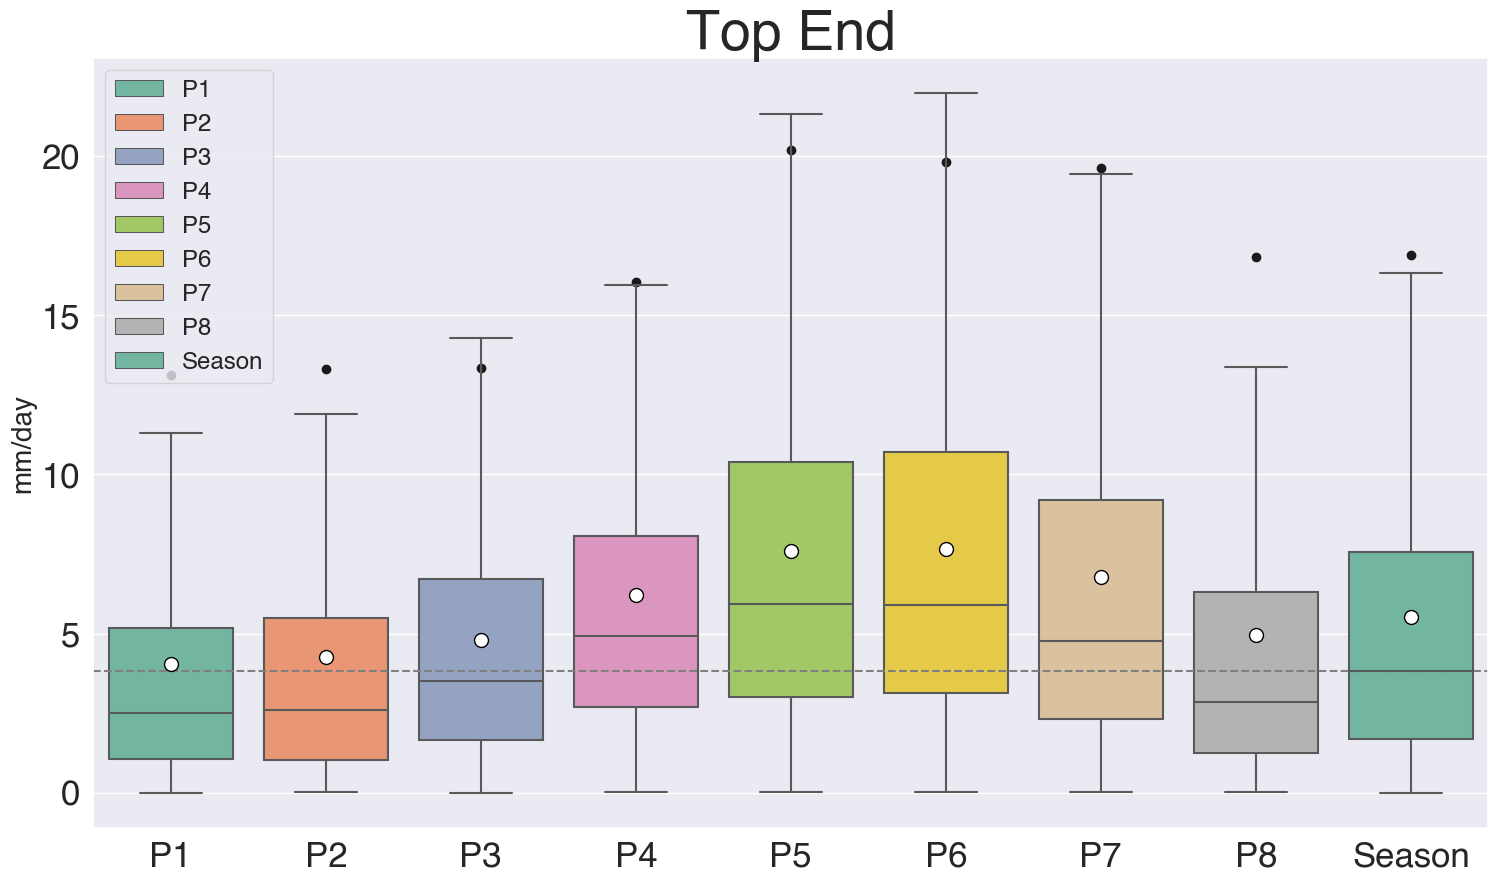

In [79]:

fig, ax = plt.subplots(1, figsize=(18, 10))

sns.boxplot(data=df_TE_plot, y='mm/day',x='Phase', hue="Phase",showfliers = False, showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
            ax = ax,
            flierprops={"marker": "x"},
            notch=False, showcaps=True,
            dodge = False,
            fliersize = 3,
            palette = 'Set2'
#            scale = "log"
           )

med_TE = prec_seas["precip"].median()

ext_TE  = df_TE_plot.groupby(["Phase"]).quantile(0.95)

ax.axhline(med_TE, 0,1, color="grey",linestyle = '--')
ax.tick_params(labelsize=25)

ax.set(xlabel= None)
ax.scatter(np.arange(0,9), ext_TE, c='k',marker="o")

ax.set_ylabel("mm/day",fontsize=20)
ax.set_title("Top End",fontsize=40)


sns.move_legend(
    ax, "upper left",
    bbox_to_anchor=(.81, .65), ncol=1, title=None, frameon=True,
)


ax[0,0].plot(m.values,'r-o',linewidth=4)
plt.legend(fontsize='x-large', title_fontsize='50')

In [70]:

ext_TE

,mm/day
Phase,
P1,13.131388
P2,13.302398
P3,13.331733
P4,16.035289
P5,20.205765
P6,19.824302
P7,19.610556
P8,16.815055
Season,16.880873


In [ ]:

# fig, ax = plt.subplots(2,2, figsize=(18, 10))

# sns.boxplot(data=df_EC_plot, x='mm/day',y='Phase', hue="Phase",
#             ax = ax[1,1],
#             flierprops={"marker": "x"},
#             notch=False, showcaps=True,
#             dodge = False,
#             fliersize = 3,
#             palette = 'Set2'
# #            scale = "log"
#            )

# sns.boxplot(data=df_CY_plot, x='mm/day',y='Phase', hue="Phase",
#             ax = ax[0,1],
#             flierprops={"marker": "x"},
#             notch=False, showcaps=True,
#             dodge = False,
#             fliersize = 3,
#             palette = 'Set2'
# #            scale = "log"
#            )

# sns.boxplot(data=df_TE_plot, x='mm/day',y='Phase', hue="Phase",
#             ax = ax[0,0],
#             flierprops={"marker": "x"},
#             notch=False, showcaps=True,
#             dodge = False,
#             fliersize = 3,
#             palette = 'Set2'
# #            scale = "log"
#            )

# sns.boxplot(data=df_KY_plot, x='mm/day',y='Phase', hue="Phase",
#             ax = ax[1,0],
#             flierprops={"marker": "x"},
#             notch=False, showcaps=True,
#             dodge = False,
#             fliersize = 3,
# #             legend = False,
#             palette = 'Set2'
# #            scale = "log"
#            )

# sns.move_legend(
#     ax[0,0], "upper left",
#     bbox_to_anchor=(.81, .65), ncol=1, title=None, frameon=True,
# )

# sns.move_legend(
#     ax[0,1], "upper left",
#     bbox_to_anchor=(.81, .65), ncol=1, title=None, frameon=True,
# )

# sns.move_legend(
#     ax[1,0], "upper left",
#     bbox_to_anchor=(.81, .65), ncol=1, title=None, frameon=True,
# )

# sns.move_legend(
#     ax[1,1], "upper left",
#     bbox_to_anchor=(.81, .65), ncol=1, title=None, frameon=True,
# )

# plot_TE = df_TE_plot[df_TE["Phase"].isin(["Season"])]
# med_TE  = plot_TE["mm/day"].median()

# plot_CY = df_CY_plot[df_CY["Phase"].isin(["Season"])]
# med_CY  = plot_CY["mm/day"].median()

# plot_KY = df_KY_plot[df_KY["Phase"].isin(["Season"])]
# med_KY  = plot_KY["mm/day"].median()

# plot_EC = df_EC_plot[df_EC["Phase"].isin(["Season"])]
# med_EC  = plot_EC["mm/day"].median()

# print(med_EC)

# ax[0,0].axvline(med_TE, 0,1, color="grey",linestyle = '--')
# ax[0,1].axvline(med_CY, 0,1, color="grey",linestyle = '--')
# ax[1,0].axvline(med_KY, 0,1, color="grey",linestyle = '--')
# ax[1,1].axvline(med_EC, 0,1, color="grey",linestyle = '--')

# ax[0,0].set_xlim(-1,30)
# ax[0,1].set_xlim(-1,30)
# ax[1,0].set_xlim(-1,30)
# ax[1,1].set_xlim(-1,30)

# # # ax[0].set_ylim(0.6,1.)
# # # ax[1].set_ylim(0.6,1.)
# # # ax[2].set_ylim(0.6,1.)

# ax[0,0].set(xlabel= None)
# ax[0,1].set(xlabel= None)
# ax[1,1].set(ylabel= None)
# ax[0,1].set(ylabel= None)

# ax[0,0].set_title("Top End")
# ax[0,1].set_title("Cape York")
# ax[1,0].set_title("Kimberley")
# ax[1,1].set_title("East Coast")

In [27]:
figname = 'boxplot_'+wave+'_'+season+'.png'
figpath = os.path.join(dirout, figname)
figpath

fig.savefig(figpath, bbox_inches='tight')

NameError: name 'wave' is not defined

NameError: name 'df_EC_plot' is not defined

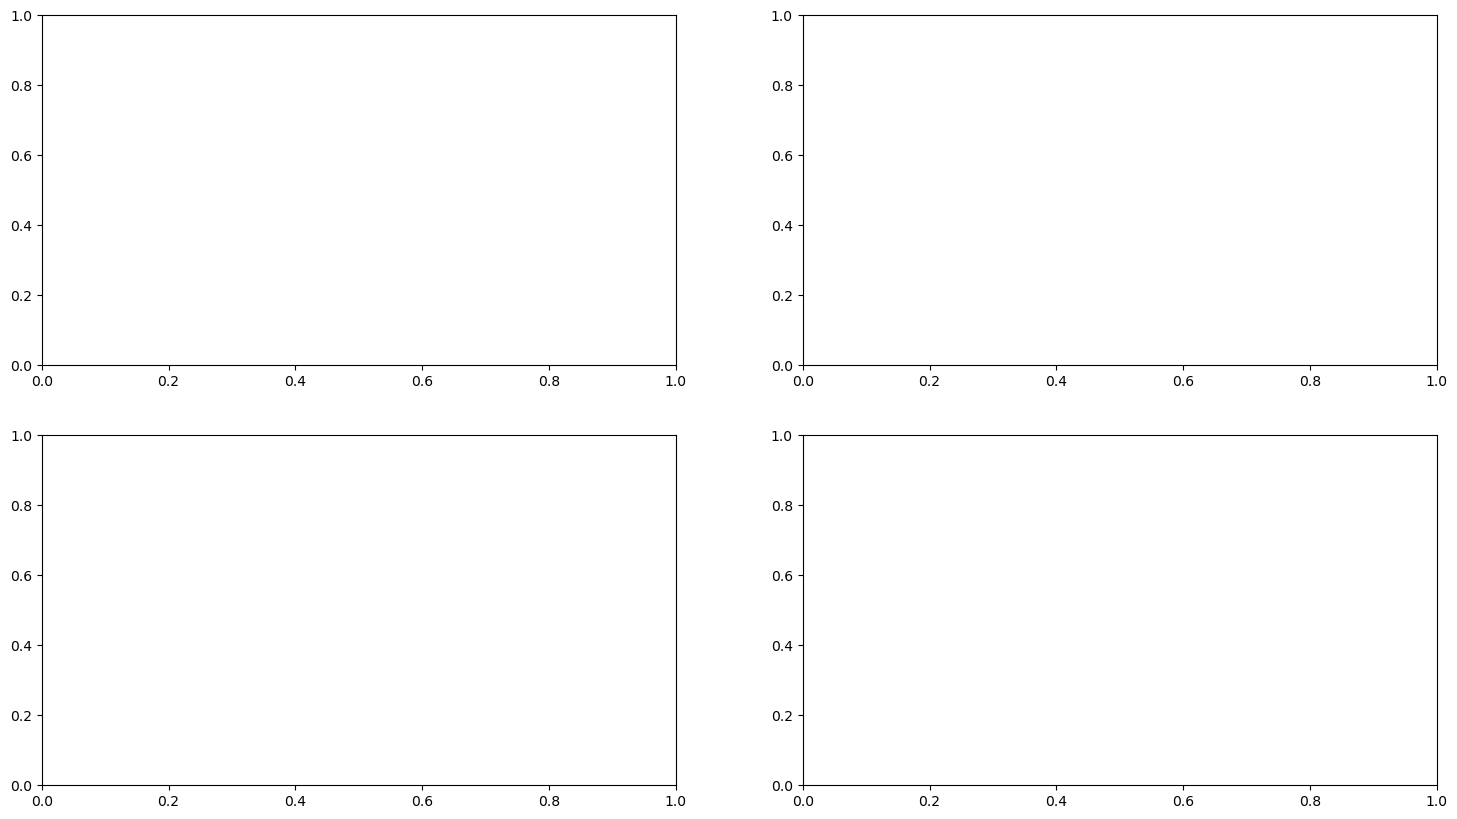

In [28]:

fig, ax = plt.subplots(2,2, figsize=(18, 10))

sns.violinplot(data=df_EC_plot, x='mm/day',y='Phase', hue="Phase",
            ax = ax[1,1],
            flierprops={"marker": "x"},
            notch=False, showcaps=True,
            dodge = False,
            fliersize = 3,
            palette = 'Set2'
#            scale = "log"
           )

sns.violinplot(data=df_CY_plot, x='mm/day',y='Phase', hue="Phase",
            ax = ax[0,1],
            flierprops={"marker": "x"},
            notch=False, showcaps=True,
            dodge = False,
            fliersize = 3,
            palette = 'Set2'
#            scale = "log"
           )

sns.violinplot(data=df_TE_plot, x='mm/day',y='Phase', hue="Phase",
            ax = ax[0,0],
            flierprops={"marker": "x"},
            notch=False, showcaps=True,
            dodge = False,
            fliersize = 3,
            palette = 'Set2'
#            scale = "log"
           )

sns.violinplot(data=df_KY_plot, x='mm/day',y='Phase', hue="Phase",
            ax = ax[1,0],
            flierprops={"marker": "x"},
            notch=False, showcaps=True,
            dodge = False,
            fliersize = 3,
#             legend = False,
            palette = 'Set2'
#            scale = "log"
           )

sns.move_legend(
    ax[0,0], "upper left",
    bbox_to_anchor=(.81, .65), ncol=1, title=None, frameon=True,
)

sns.move_legend(
    ax[0,1], "upper left",
    bbox_to_anchor=(.81, .65), ncol=1, title=None, frameon=True,
)

sns.move_legend(
    ax[1,0], "upper left",
    bbox_to_anchor=(.81, .65), ncol=1, title=None, frameon=True,
)

sns.move_legend(
    ax[1,1], "upper left",
    bbox_to_anchor=(.81, .65), ncol=1, title=None, frameon=True,
)

plot_TE = df_TE_plot[df_TE["Phase"].isin(["Season"])]
med_TE  = plot_TE["mm/day"].median()

plot_CY = df_CY_plot[df_CY["Phase"].isin(["Season"])]
med_CY  = plot_CY["mm/day"].median()

plot_KY = df_KY_plot[df_KY["Phase"].isin(["Season"])]
med_KY  = plot_KY["mm/day"].median()

plot_EC = df_EC_plot[df_EC["Phase"].isin(["Season"])]
med_EC  = plot_EC["mm/day"].median()

print(med_EC)

ax[0,0].axvline(med_TE, 0,1, color="grey",linestyle = '--')
ax[0,1].axvline(med_CY, 0,1, color="grey",linestyle = '--')
ax[1,0].axvline(med_KY, 0,1, color="grey",linestyle = '--')
ax[1,1].axvline(med_EC, 0,1, color="grey",linestyle = '--')

ax[0,0].set_xlim(-1,30)
ax[0,1].set_xlim(-1,30)
ax[1,0].set_xlim(-1,30)
ax[1,1].set_xlim(-1,30)

# # ax[0].set_ylim(0.6,1.)
# # ax[1].set_ylim(0.6,1.)
# # ax[2].set_ylim(0.6,1.)

ax[0,0].set(xlabel= None)
ax[0,1].set(xlabel= None)
ax[1,1].set(ylabel= None)
ax[0,1].set(ylabel= None)

ax[0,0].set_title("Top End")
ax[0,1].set_title("Cape York")
ax[1,0].set_title("Kimberley")
ax[1,1].set_title("East Coast")